In [23]:
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt                                           
import seaborn as sns                                                    

from collections import Counter                                                 

import re, string, unicodedata                                                  
import contractions                                                             
from bs4 import BeautifulSoup                                                   

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator                 
import nltk                                                                     
from nltk.corpus import stopwords                                               
from nltk.tokenize import word_tokenize, sent_tokenize                          
from nltk.stem.wordnet import WordNetLemmatizer                                 
from nltk.stem.porter import PorterStemmer                                     

from sklearn.feature_extraction.text import CountVectorizer                     
from sklearn.feature_extraction.text import TfidfVectorizer                     

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier                             
from sklearn.metrics import classification_report                               
from sklearn.model_selection import cross_val_score 

# download stopwords
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:

import warnings
warnings.filterwarnings('ignore')


pd.set_option(
    "display.float_format", lambda x: "%.2f" % x
)  # to display numbers rounded to 2 decimal places

In [25]:

path1 = "Tweets.csv"
tweets = pd.read_csv(path1)
df = tweets.copy()

In [26]:
df.shape

(14640, 15)

In [27]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.00,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.35,NaN,0.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.68,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.00,Bad Flight,0.70,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.00,Can't Tell,1.00,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [33]:
for col in df.columns[df.dtypes=='object']:
    df[col] = df[col].astype('category')

In [34]:
df['tweet_id'] = df['tweet_id'].astype('category')

In [36]:
df['tweet_created'] = df['tweet_created'].dt.tz_localize(None)

# Now, you can convert it to 'datetime64[ns]' dtype
df['tweet_created'] = df['tweet_created'].astype('datetime64[ns]')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  category      
 1   airline_sentiment             14640 non-null  category      
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   category      
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  category      
 6   airline_sentiment_gold        40 non-null     category      
 7   name                          14640 non-null  category      
 8   negativereason_gold           32 non-null     category      
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  category      
 11  tweet_coord                 

In [38]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
airline_sentiment_confidence,14640.00,0.90,0.34,0.69,1.00,1.00,1.00,0.16
negativereason_confidence,10522.00,0.64,0.00,0.36,0.67,1.00,1.00,0.33
retweet_count,14640.00,0.08,0.00,0.00,0.00,0.00,44.00,0.75
tweet_created,14640,2015-02-21 11:33:24.781216,2015-02-16 23:36:05,2015-02-19 15:54:05.750000128,2015-02-22 04:44:35.500000,2015-02-23 08:04:11,2015-02-24 11:53:37,NaN


In [39]:
# show summary of all categorical variables
df.describe(include=['category']).T

,count,unique,top,freq
tweet_id,14640,14485,570281470507352064,2
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_location,9907,3081,"Boston, MA",157


In [40]:
# show summary of datetime variable
df.describe(include=['datetime']).T

,count,mean,min,25%,50%,75%,max
tweet_created,14640,2015-02-21 11:33:24.781216,2015-02-16 23:36:05,2015-02-19 15:54:05.750000128,2015-02-22 04:44:35.500,2015-02-23 08:04:11,2015-02-24 11:53:37


In [41]:
# show number of tweets by day
by_date = df.groupby(pd.Grouper(key='tweet_created', axis=0, freq='D')).count()['tweet_id']
print(by_date)

tweet_created
2015-02-16       4
2015-02-17    1408
2015-02-18    1344
2015-02-19    1376
2015-02-20    1500
2015-02-21    1557
2015-02-22    3079
2015-02-23    3028
2015-02-24    1344
Freq: D, Name: tweet_id, dtype: int64


In [42]:
# function to create labeled barplots

def labeled_barplot(data, feature, hue=None, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    hue: whether to groupby another dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
        
    ax = sns.countplot(
        data=data,
        x=feature,
        hue=hue,
        palette='viridis',
        order = data[feature].value_counts().index,
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points"
        )  # annotate the percentage

    plt.show()  # show the plot

In [43]:
# import the figure size for the visualizations
from matplotlib import rcParams

In [44]:
# show number of tweets by sentiment
df.airline_sentiment.value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

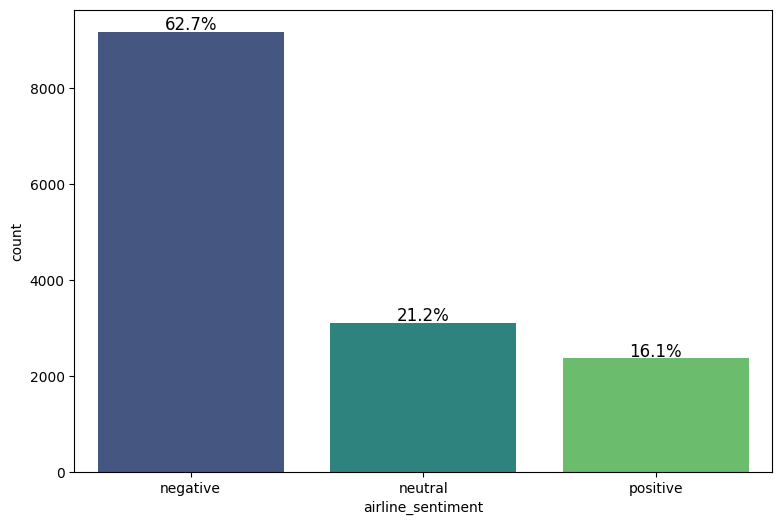

In [45]:
rcParams['figure.figsize'] = 9,6
labeled_barplot(df,'airline_sentiment',perc=True)

In [46]:
# show number of tweets by airline
df.airline.value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

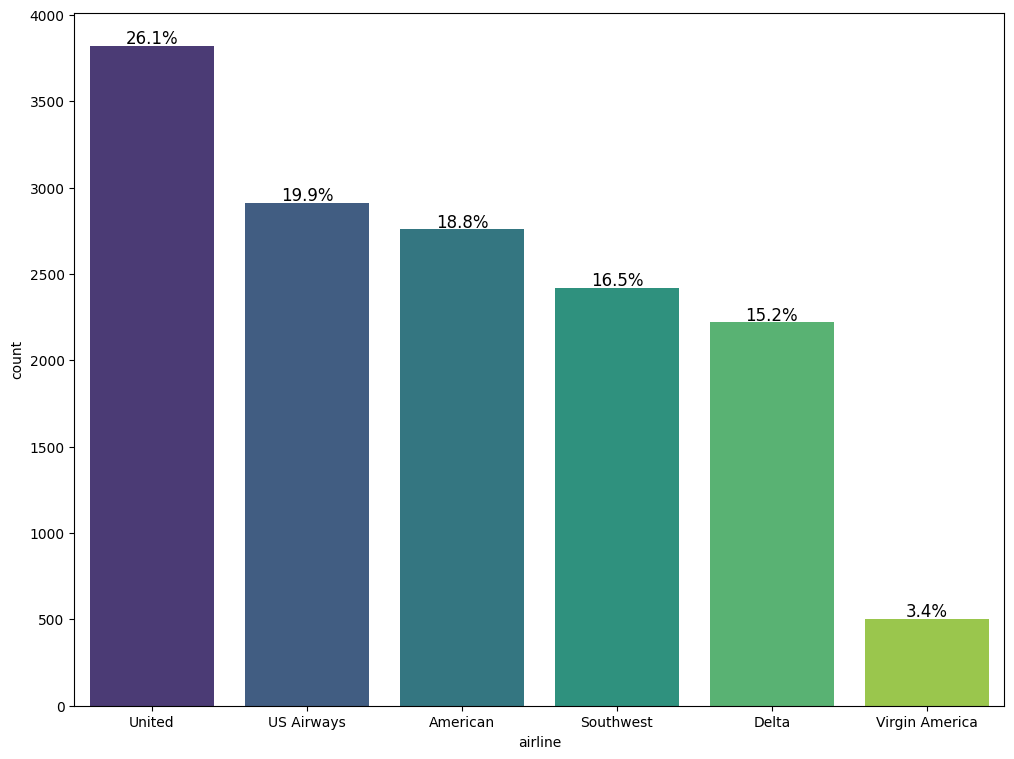

In [47]:
# create labeled barplot of number of tweets by airline
rcParams['figure.figsize'] = 12,9
labeled_barplot(df,'airline',perc=True)

In [48]:
# show number of tweets by sentiment per airline
df.groupby('airline')['airline_sentiment'].value_counts()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: count, dtype: int64

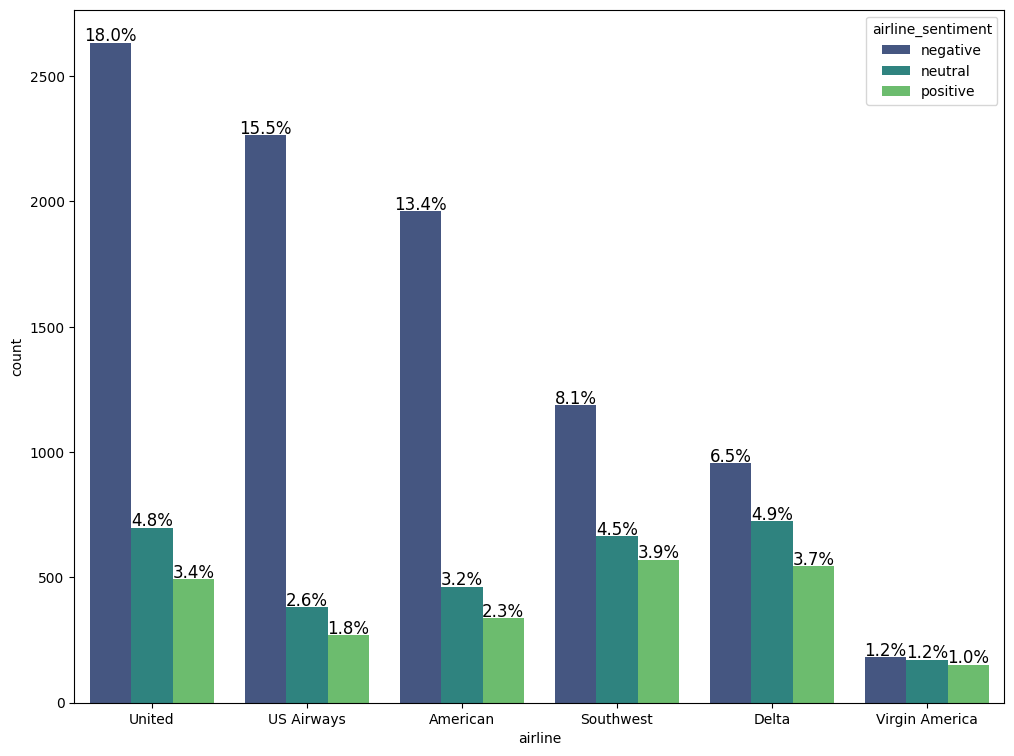

In [49]:
# create labeled barplot for number of tweets by sentiment per airline
labeled_barplot(df,'airline','airline_sentiment',perc=True)

In [50]:
# show number of tweets by reason for negative sentiment
df.negativereason.value_counts()

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

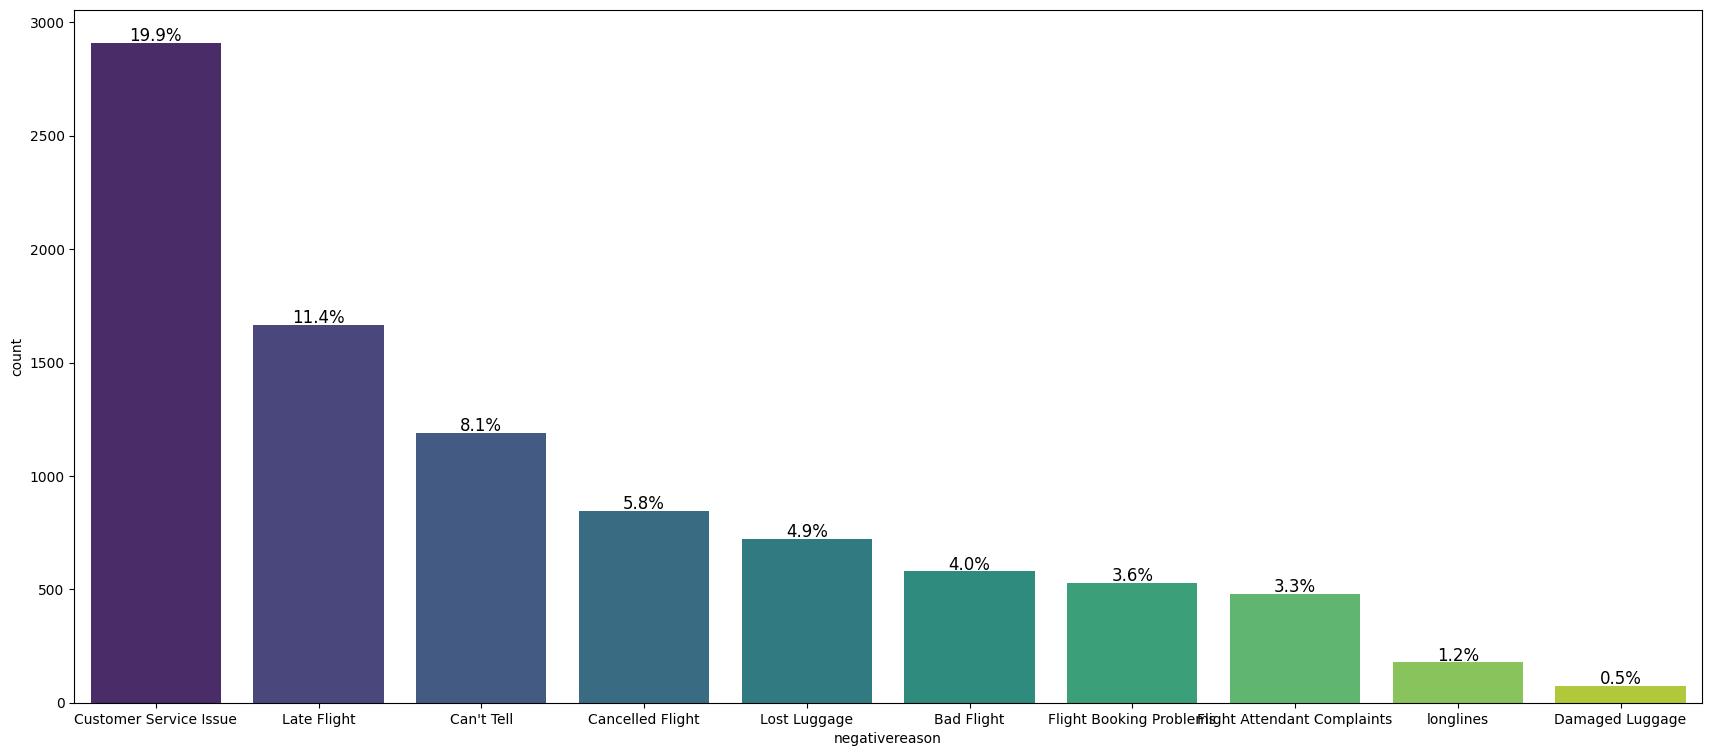

In [51]:
# create labeled barplot for number of tweets per reason for negative sentiment
rcParams['figure.figsize'] = 21,9
labeled_barplot(df,'negativereason',perc=True)

In [52]:
def wordcloud(tweets):
  words = ' '.join(tweets['text'])
  cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
  wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
  plt.figure(1,figsize=(12, 12))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

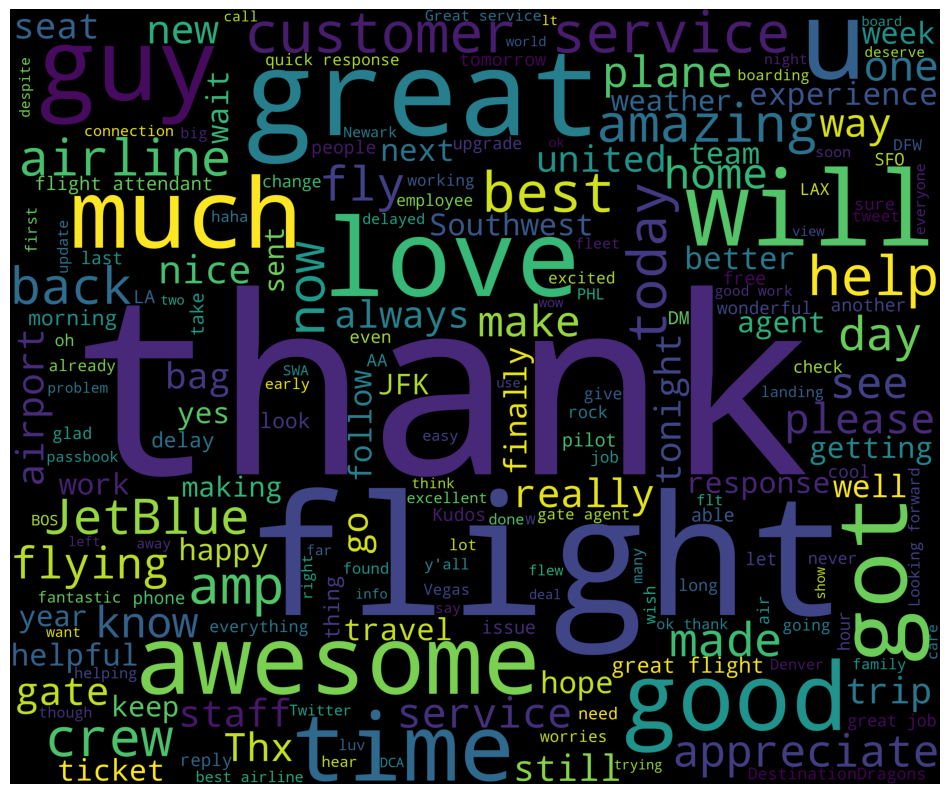

In [53]:
# create word cloud for positive tweets
pos_tweets = df[df['airline_sentiment']=='positive']
wordcloud(pos_tweets)

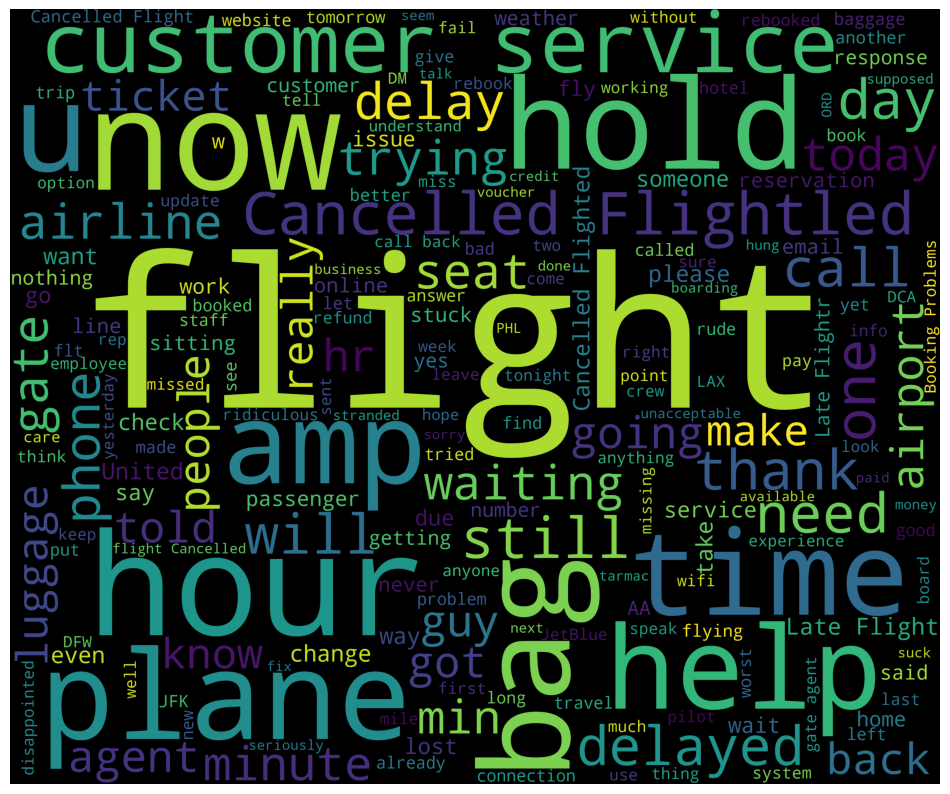

In [54]:
# create world cloud for negative tweets
neg_tweets = df[df['airline_sentiment']=='negative']
wordcloud(neg_tweets)

In [55]:
column_list = df.columns.to_list()

In [56]:
# identify columns used for model building
columns = ['text','airline_sentiment']

In [57]:
# identify columns to be dropped
drop_columns = [col for col in column_list if col not in columns]
print(drop_columns)

['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [58]:

# drop all other columns except “text” and “airline_sentiment”
df_model = df.drop(columns = drop_columns)

In [60]:
df_model.shape

(14640, 2)

In [61]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (non-turncated text column.)
#print head of new dataset
df_model.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [62]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# remove the url's present in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove the mentions in the tweets
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text = remove_url(text)
    text = remove_mention(text)
    return text
df_model['text'] = df_model['text'].apply(lambda x: clean_text(x))
df_model.head()


,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experience... tacky.
2,neutral,I did not today... Must mean I need to take another trip!
3,negative,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,and it is a really big bad thing about it


In [63]:
df_model['text'] = df_model.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # tokenization of data
df_model.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[and, it, is, a, really, big, bad, thing, about, it]"


In [64]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
stopwords = stopwords.words('english')
custom_remove_list = ['flight']
stopwords = list(set(stopwords)) + custom_remove_list
lemmatizer = WordNetLemmatizer()

# remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# remove the hashtags
def remove_hash(text):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df_model['text'] = df_model.apply(lambda row: normalize(row['text']), axis=1)
df_model.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainment guests face little recourse
4,negative,really big bad thing


In [66]:
# set independent variable for classification model
targets = sorted(df_model.airline_sentiment.unique().to_list())
print(targets)

['negative', 'neutral', 'positive']


In [67]:
# set the max number of features at 1000
count_vec = CountVectorizer(max_features=1000)
# convert text to numbers with CountVectorizer
data_features_count = count_vec.fit_transform(df_model['text'])
# convert the data features to array
data_features_count = data_features_count.toarray() 

In [68]:
# show shape of the feature vector
data_features_count.shape

(14640, 1000)

In [69]:
# split data into training and testing set
X_count = data_features_count
y = df_model.airline_sentiment
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.25, shuffle=False, random_state=42)


In [70]:
# find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_count, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

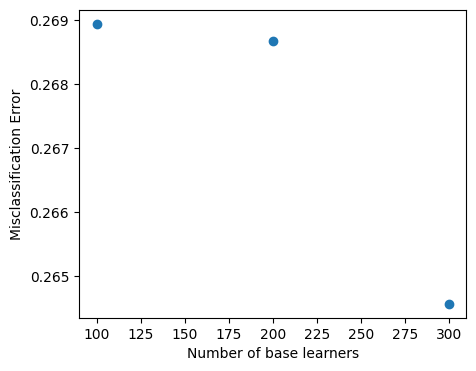

In [72]:
# set figure size
rcParams['figure.figsize'] = 5,4
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [73]:
# train the best model
clf_count = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf_count.fit(X_train_count, y_train)
clf_count.score(X_test_count, y_test)
count_predicted = clf_count.predict(X_test_count)

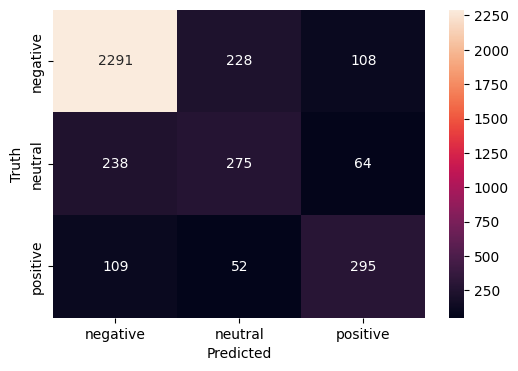

In [75]:
from sklearn.metrics import confusion_matrix
#create confusion matrix for Count Vectorizer
cm_count=confusion_matrix(y_test,count_predicted)

plt.figure(figsize=(6,4))
sns.heatmap(cm_count,annot=True,fmt='d',xticklabels=targets , yticklabels= targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [78]:
# Assuming clf_count is your trained classifier and count_vec is your fitted CountVectorizer
all_features_count = count_vec.get_feature_names_out()  # Get the feature names from CountVectorizer
feat = clf_count.feature_importances_
features = np.argsort(feat)[::-1]
top_features_count = ''

for i in features[:40]:  # Use [:40] instead of [0:40] to get the top 40 features
    top_features_count += all_features_count[i]
    top_features_count += ', '

top_features_count


'thank, delay, great, love, hours, hold, awesome, cancel, bag, get, hour, amaze, best, fly, wait, please, would, worst, plane, customer, time, call, service, help, fleek, lose, go, make, never, late, need, still, say, miss, flight, try, luggage, tell, fleet, good, '

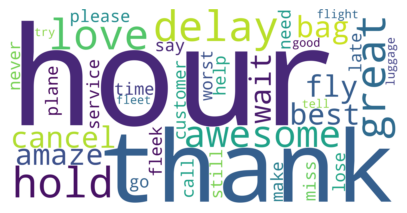

In [79]:
from wordcloud import WordCloud
# create word cloud
wordcloud_count = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features_count)

# show word cloud
plt.imshow(wordcloud_count, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [80]:
# saving variables for model
y_train_count = y_train
y_test_count = y_test

In [81]:
# set the max number of features at 1000
tfidf_vec = TfidfVectorizer(max_features=1000)
# convert test to numbers with TfidfVectorizer
data_features_idf = tfidf_vec.fit_transform(df_model['text'])
# convert the data features to array
data_features_idf = data_features_idf.toarray() 

In [82]:
data_features_idf.shape

(14640, 1000)

In [83]:
# split data into training and testing set
X_idf = data_features_idf
y = df_model.airline_sentiment
X_train_idf, X_test_idf, y_train, y_test = train_test_split(X_idf, y, test_size=0.25, shuffle=False, random_state=42)

In [84]:
# find the optimal number of base learners using k-fold cross-validation (CV)
base_ln = np.arange(100,400,100).tolist()

# train model with k-fold CV
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_idf, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

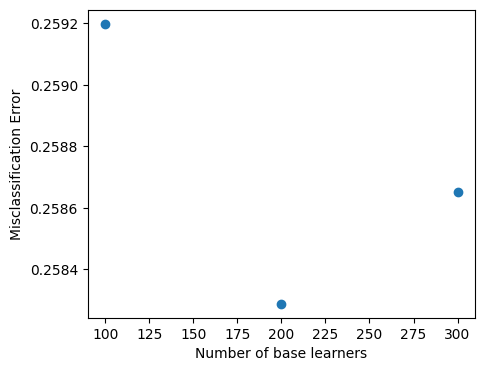

In [85]:
# plot the error as k-fold increases
error = [1 - x for x in cv_scores]                                              # error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                             # optimal number of n_estimator selected by minimum error
plt.scatter(base_ln, error)                                                     # plot number of estimators with corresponding misclassification error
xy = (optimal_learners, min(error))
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [86]:
# train the best model
clf = RandomForestClassifier(n_estimators = optimal_learners, random_state=42)
clf.fit(X_train_idf, y_train)
clf.score(X_test_idf, y_test)
tf_idf_predicted = clf.predict(X_test_idf)

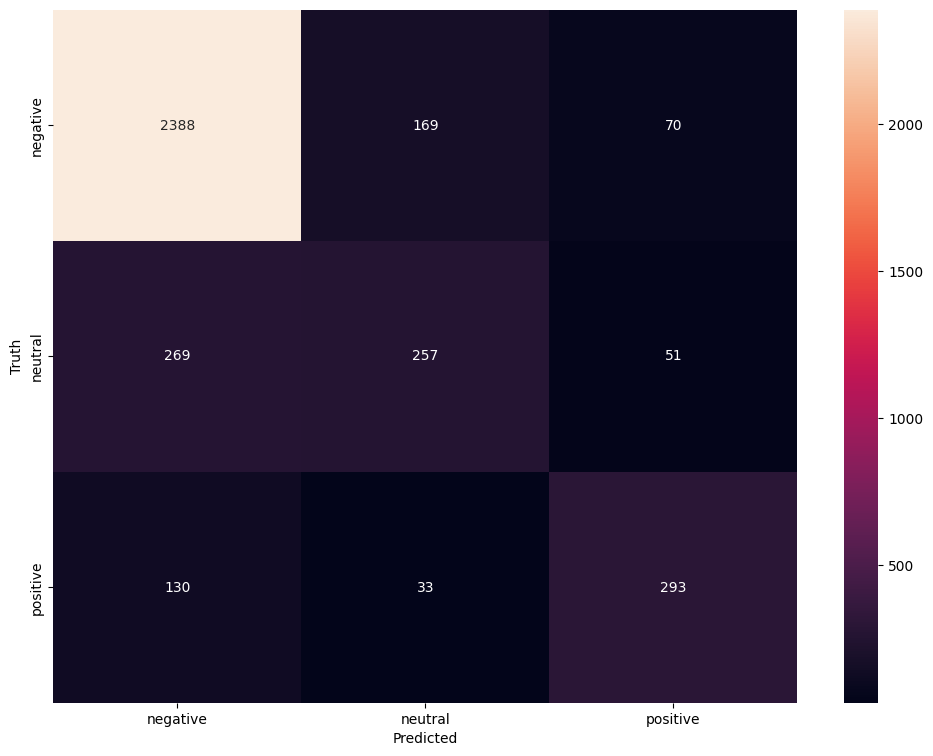

In [87]:
# create confusion matrix for TF-IDF Vectorizer
cm_tfidf=confusion_matrix(y_test , tf_idf_predicted)

plt.figure(figsize=(12,9))
sns.heatmap(cm_tfidf,annot=True,fmt='d',xticklabels=targets , yticklabels=targets)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Assuming you have already trained and fitted your TF-IDF vectorizer (tfidf_vec) and classifier (clf)
# Get the feature names from the TF-IDF vectorizer
all_features = tfidf_vec.get_feature_names_out()

# Get feature importances from the classifier
feat = clf.feature_importances_

# Sort the features by importance in descending order
features = np.argsort(feat)[::-1]

# Initialize an empty string to store the top 40 features
top_features = ''

# Concatenate the top 40 features into the 'top_features' string
for i in features[:40]:
    top_features += all_features[i] + ', '

# Print or use the 'top_features' string as needed
print(top_features)


thank, delay, great, love, hours, hold, cancel, get, awesome, bag, best, amaze, hour, fly, please, fleek, wait, service, would, time, make, follow, plane, fleet, customer, call, flight, good, help, need, dm, know, worst, go, airline, say, never, lose, still, late, 


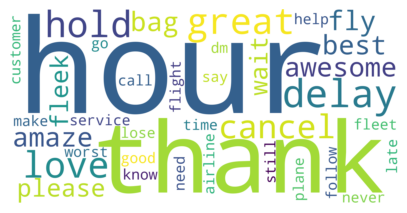

In [90]:
from wordcloud import WordCloud
# create word cloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# show word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(15, 12), frameon='equal')
plt.axis("off")
plt.show()

In [91]:
# saving variables for model
y_train_idf = y_train
y_test_idf = y_test

In [92]:
# provide a classification report on the Count Vectorizer model
print("Random Forest model trained with Count Vectorizer data")
print(" ")
print(classification_report(y_test_count , count_predicted, target_names = targets))
print(" ")

# provide a classification report on the TF-IDF Vectorizer model
print("Random Forest model trained with TF-IDF Vectorizer data")
print(" ")
print(classification_report(y_test_idf , tf_idf_predicted, target_names = targets))
print(" ")

Random Forest model trained with Count Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87      2627
     neutral       0.50      0.48      0.49       577
    positive       0.63      0.65      0.64       456

    accuracy                           0.78      3660
   macro avg       0.67      0.67      0.67      3660
weighted avg       0.78      0.78      0.78      3660

 
Random Forest model trained with TF-IDF Vectorizer data
 
              precision    recall  f1-score   support

    negative       0.86      0.91      0.88      2627
     neutral       0.56      0.45      0.50       577
    positive       0.71      0.64      0.67       456

    accuracy                           0.80      3660
   macro avg       0.71      0.67      0.68      3660
weighted avg       0.79      0.80      0.80      3660

 
